In [151]:
import os
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K

In [152]:
# --- Custom Metrics ---
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
# #@tf.keras.utils.register_keras_serializable()
# def custom_loss(y_true, y_pred):
#     # Replace this with your actual loss logic if needed
#     return tf.keras.losses.binary_crossentropy(y_true, y_pred)
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [153]:
model = tf.keras.models.load_model(
    "ed_unet_model_b8_ep80_0.9340.keras",
    custom_objects={
        'dice_coefficient': dice_coefficient,
        'iou_metric': iou_metric,
        'precision': precision,
        'recall': recall,
        'dice_loss': dice_loss  # <- required!
    }
)


In [154]:
# # --- Threshold Binary Mask ---
def threshold_mask(mask):
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)
    return binary_mask / 255.0
# def threshold_mask(mask_arr, threshold=0.5):
#     return (mask_arr > threshold).astype(np.float32)


In [155]:
def load_test_data_from_folder(test_data_dir, phase="ED", img_size=(256, 256)):
    X_test, y_test, filenames = [], [], []

    for patient_folder in sorted(os.listdir(test_data_dir)):
        folder_path = os.path.join(test_data_dir, patient_folder, phase)
        image_folder = os.path.join(folder_path, "images")
        mask_folder = os.path.join(folder_path, "masks")

        if not os.path.isdir(image_folder) or not os.path.isdir(mask_folder):
            print(f"Skipping {patient_folder} — missing folders")
            continue

        # Find matching image and mask file names
        image_files = sorted([f for f in os.listdir(image_folder) if f.endswith(".png")])
        mask_files = sorted([f for f in os.listdir(mask_folder) if f.endswith(".png")])

        for img_file in image_files:
            # Assume mask file ends with "_gt.png"
            mask_file = img_file.replace(".png", "_gt.png")
            if mask_file not in mask_files:
                print(f"Missing mask for {img_file} in {patient_folder}")
                continue

            img_path = os.path.join(image_folder, img_file)
            mask_path = os.path.join(mask_folder, mask_file)

            img = load_img(img_path, color_mode="rgb", target_size=img_size)
            mask = load_img(mask_path, color_mode="grayscale", target_size=img_size)

            img_arr = img_to_array(img) / 255.0
            mask_arr = img_to_array(mask).squeeze()
            mask_bin = threshold_mask(mask_arr)
            mask_bin = np.expand_dims(mask_bin, axis=-1)

            X_test.append(img_arr)
            y_test.append(mask_bin)
            filenames.append((patient_folder, img_file))

    return np.array(X_test), np.array(y_test), filenames

In [156]:
# import os

# test_dir = "/home/meth/Documents/ETH/DCM/ed_test_data"
# phase = "ed"

# patient_folder = "patient0174"
# image_folder = os.path.join(test_dir, patient_folder, phase, "images")
# mask_folder  = os.path.join(test_dir, patient_folder, phase, "masks")

# print("Image folder:", image_folder, "Exists?", os.path.isdir(image_folder))
# print("Mask folder:", mask_folder, "Exists?", os.path.isdir(mask_folder))


# base = "/home/meth/Documents/ETH/DCM/ed_test_data"

# for root, dirs, files in os.walk(base):
#     for f in files:
#         if f.endswith(".png"):
#             print("FOUND IMAGE:", os.path.join(root, f))



In [157]:
# --- Visualize with Overlay ---
def visualize_predictions(X, y_true, preds, sample_indices=[0, 1, 2]):
    for i in sample_indices:
        image = X[i].squeeze()
        true_mask = y_true[i].squeeze()
        pred_mask = (preds[i].squeeze() > 0.5).astype(np.uint8)

        plt.figure(figsize=(15, 4))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image, cmap='gray')
        plt.title("Input Image")
        plt.axis("off")

        # Ground truth overlay
        plt.subplot(1, 3, 2)
        plt.imshow(image, cmap='gray')
        plt.imshow(true_mask, cmap='Reds', alpha=0.5)
        plt.title("Ground Truth (LV)")
        plt.axis("off")

        # Predicted mask overlay
        plt.subplot(1, 3, 3)
        plt.imshow(image, cmap='gray')
        plt.imshow(pred_mask, cmap='Blues', alpha=0.5)
        plt.title("Predicted (LV)")
        plt.axis("off")

        plt.tight_layout()
        plt.show()


Loaded 50 test samples.
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9856 - dice_coefficient: 0.9377 - iou_metric: 0.8829 - loss: 0.0642

Evaluation Metrics:
loss: 0.0617
compile_metrics: 0.9861
2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


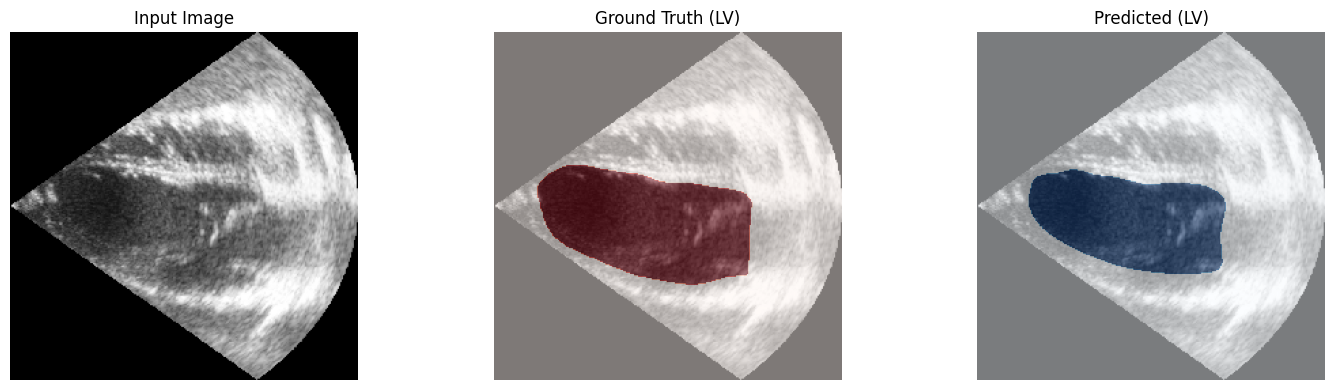

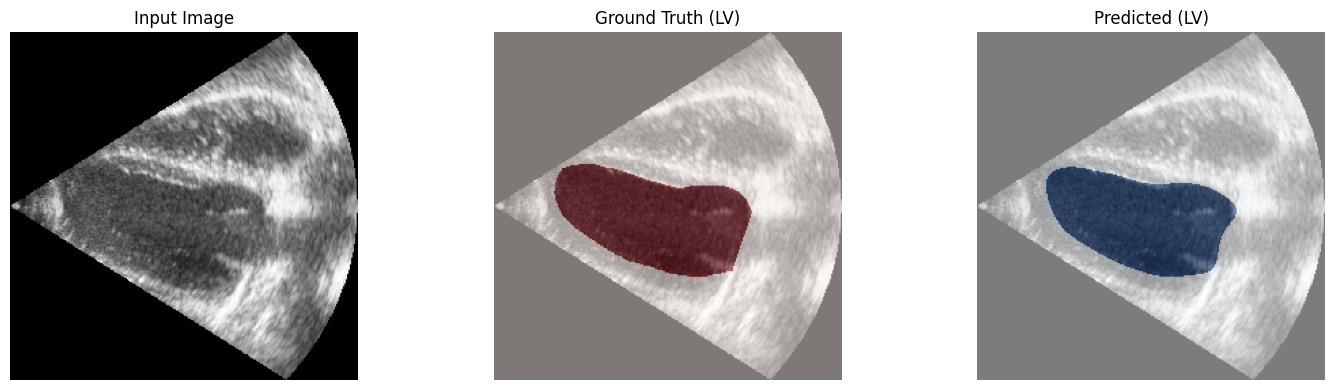

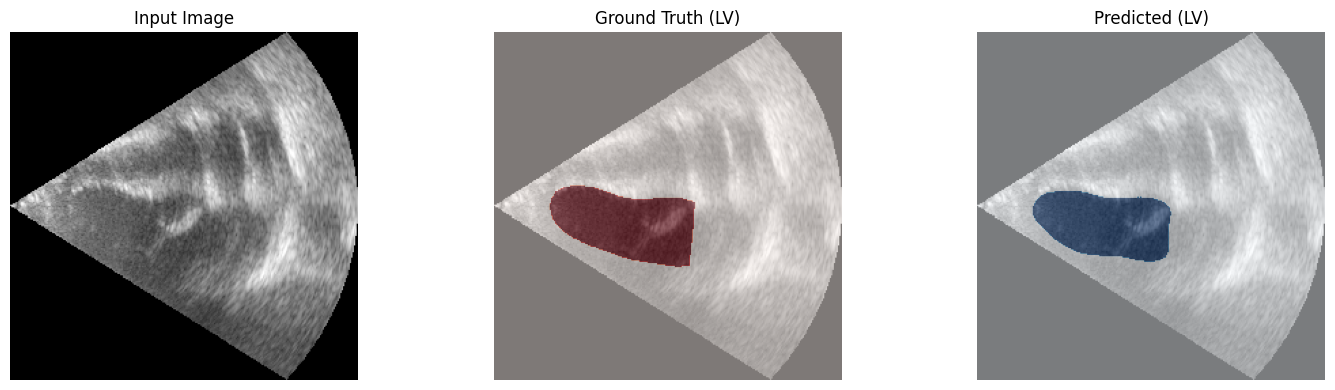

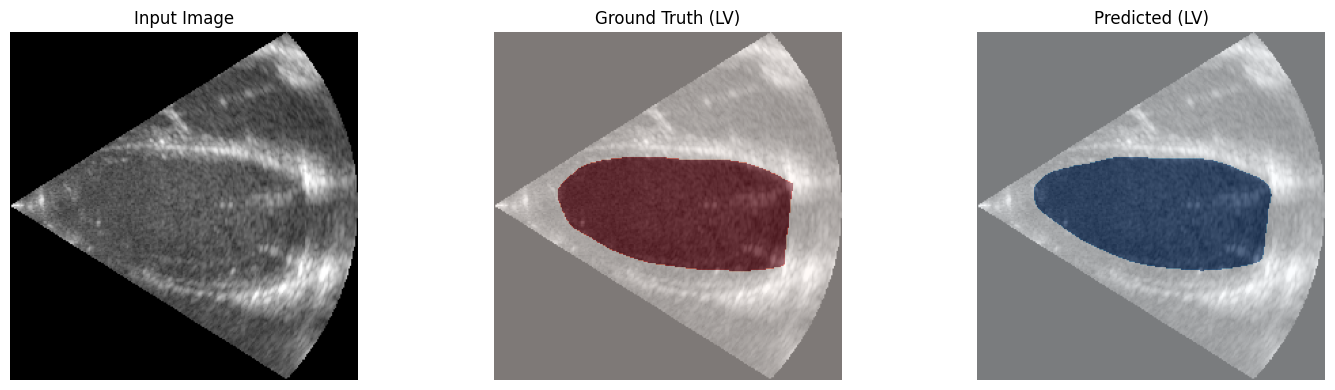

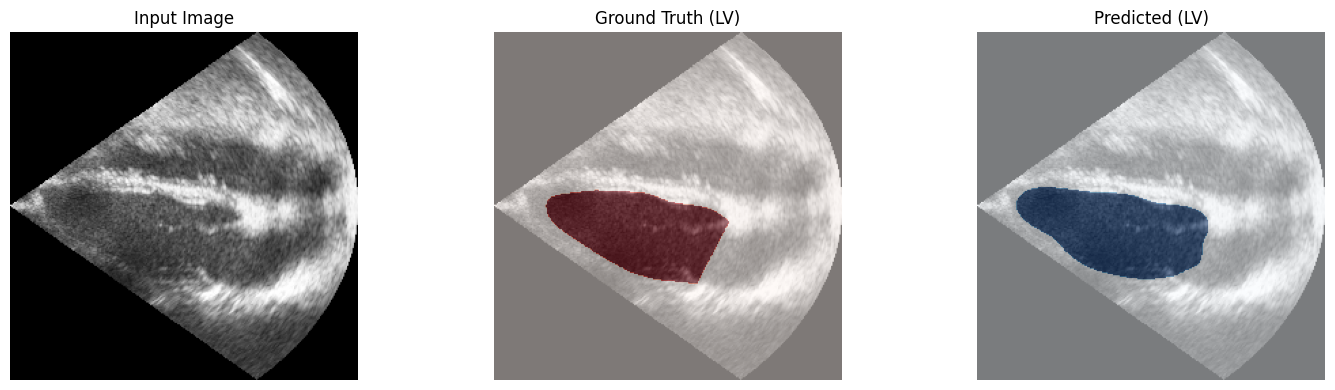

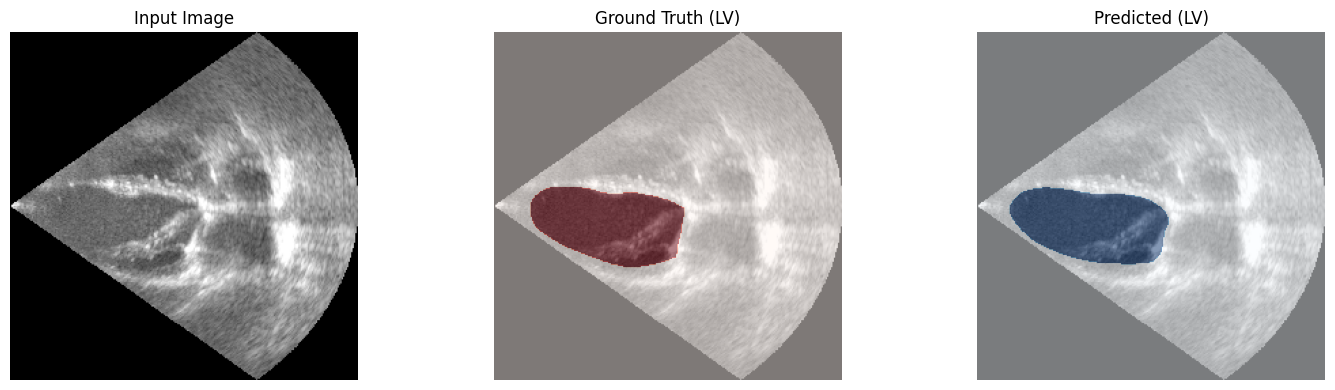

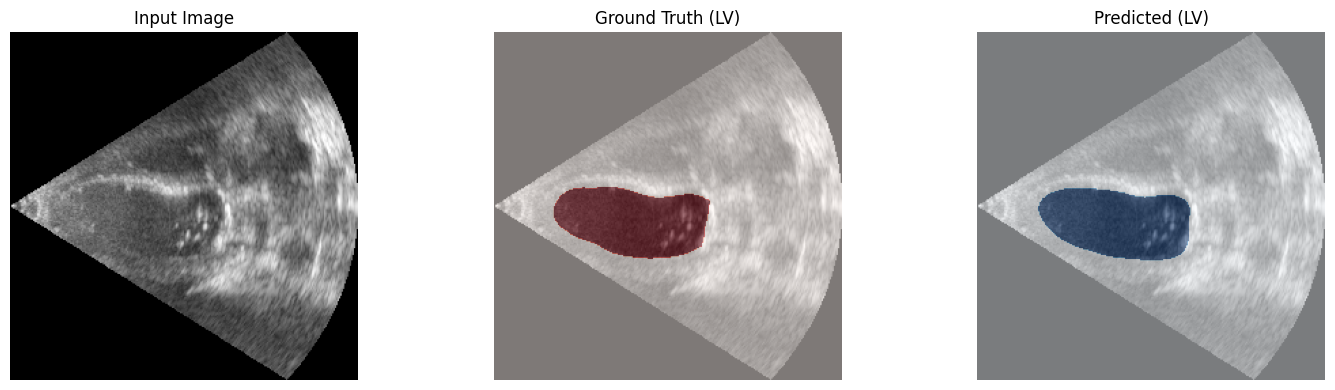

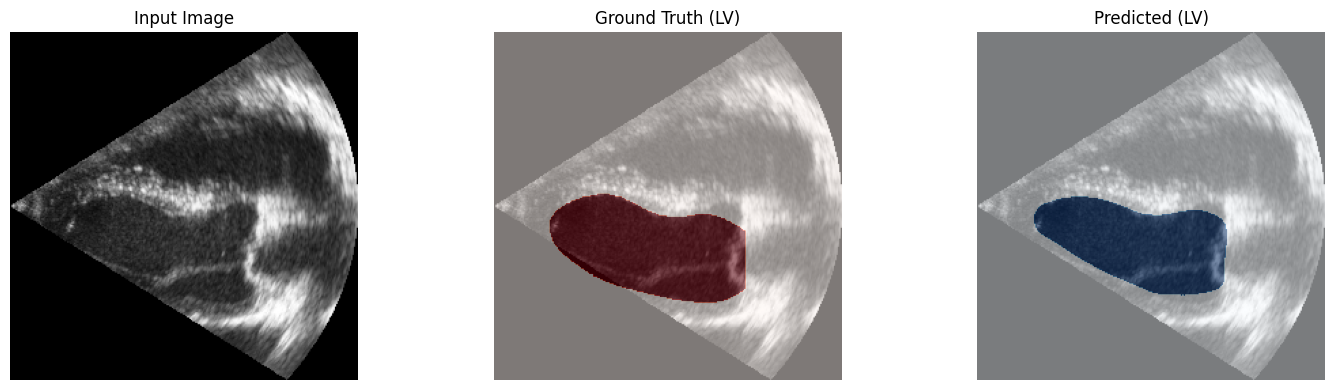

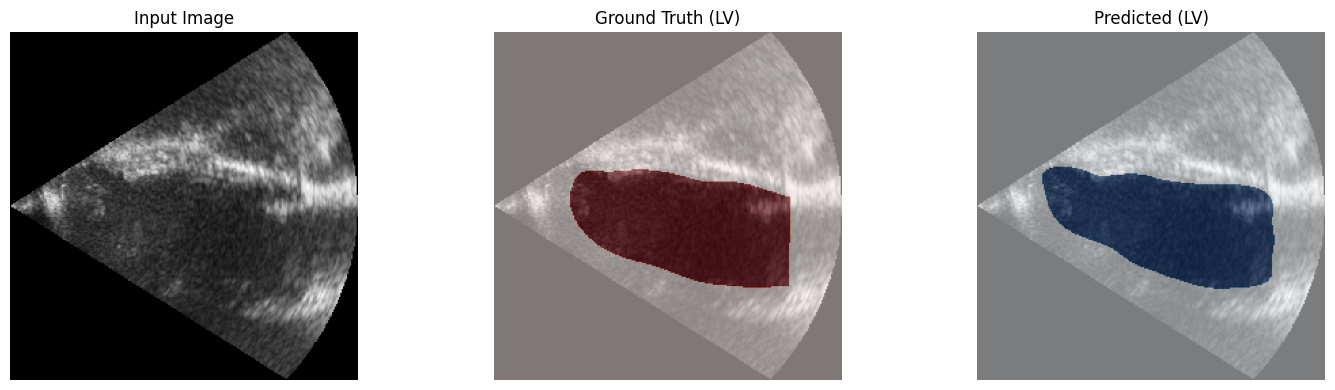

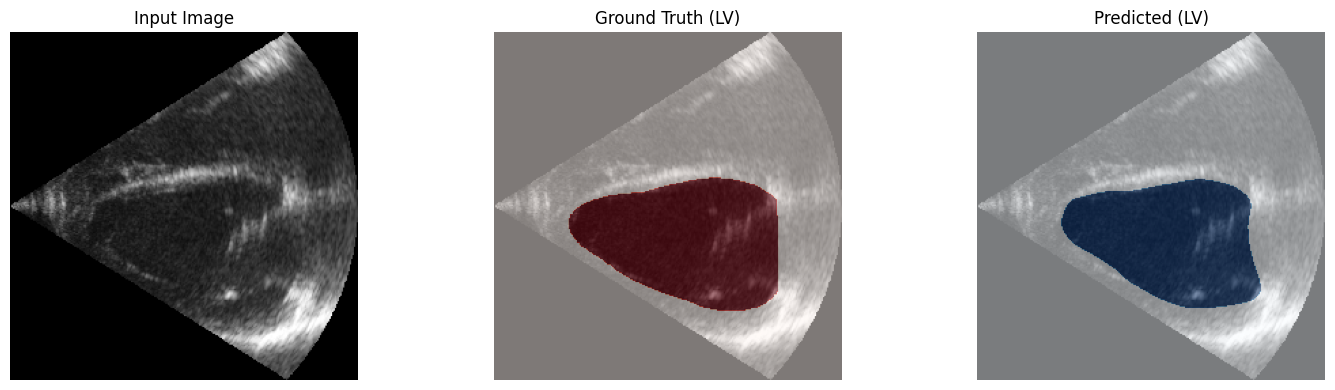

In [158]:
if __name__ == "__main__":
    test_dir = "/home/meth/Documents/ETH/DCM/ed_test_data"

    X_test, y_test, filenames = load_test_data_from_folder(test_dir, phase="ED")

    if len(X_test) == 0:
        print("No test samples found.")
    else:
        print(f"Loaded {len(X_test)} test samples.")

# Evaluate and visualize after model is loaded externally
        results = model.evaluate(X_test, y_test, verbose=1)
        print("\nEvaluation Metrics:")
        for name, value in zip(model.metrics_names, results):
            print(f"{name}: {value:.4f}")
        preds = model.predict(X_test, verbose=1)
        visualize_predictions(X_test, y_test, preds, sample_indices=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])